In [1]:
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
import warnings
warnings.simplefilter('ignore')

In [238]:
data = pd.read_csv("data-news.csv")
docs = data["title"]
[d for d in docs][:10]

['Kuarentena Iha Uma, MS Husu Atu Toba Dook Malu Metru Ida Hosi Ema Seluk',
 'Estudante ICS Nain Ida Pozitivu Covid-19: Sai Hosi Dili Ba Baucau Iha Loron Ida Antes Lockdown',
 'Covid-19: Ema Na’in-2 Mak Mate Tán No Infetadu Foun Na’in-179',
 'Pasiente Covid-19 Ida Krítiku No Lima Grave Iha Izolamentu Vera-Krúz',
 'Covid-19: Kazu Pozitivu Foun Na’in-133 No Rekuperadu Foun Na’in-129',
 'Covid-19: Ohin SIJK Informa Kazu Mate Timoroan Na’in-1 Ho Sexu Feto',
 'Primeiru-Ministru Retoma Servisu Hafoin Rekupera Ona Hosi Covid-19',
 'PM Husu Sidadaun Sira Tenke Simu Vasina Hodi Hein Papa Francisco Nia Vizita Mai Timor-Leste',
 'Covid-19: Ohin MS Relata Kazu Mate 4 Inklui Mane Ida Simu Ona Vasina Doze Kompletu',
 'Governu Sei Haree Atu Taka Fronteira Iha Tempu Badak Hodi Evita Variante Delta']

In [257]:
cv = CountVectorizer()
term_cv = cv.fit_transform(docs)
term = np.array(cv.get_feature_names())
term_freq = term_cv.toarray().sum(axis=0)
tf = dict(zip(term, term_freq))
dict_tf = dict(sorted(tf.items(), key=lambda x: x[1], reverse=True))
df_tf = pd.DataFrame.from_dict(dict_tf, orient='index', columns=["tf"])[:10]
df_tf.rename_axis("term", axis=1)

term,tf
ba,226
iha,201
no,91
atu,89
governu,88
ho,72
ona,64
19,60
sei,60
covid,56


In [256]:
tfidf_transformer = TfidfTransformer()
X = tfidf_transformer.fit_transform(term_cv)
idf = pd.DataFrame({'term':cv.get_feature_names(), 'idf':tfidf_transformer.idf_})
idf.sort_values(by='idf', ascending=False)[:10]

,term,idf
1349,úniku,6.400423
602,jeneralidade,6.400423
588,investiga,6.400423
589,inválidu,6.400423
590,iom,6.400423
592,iregularidade,6.400423
594,israel,6.400423
595,istória,6.400423
1114,rumoris,6.400423
597,ita,6.400423


In [255]:
count_vector = cv.transform(docs)
tf_idf_vec = tfidf_transformer.transform(count_vector)
first_doc_vec = tf_idf_vec[0]
df_tfidf = pd.DataFrame(first_doc_vec.T.todense(), index=term, columns=["tfidf"])
df_tfidf_10 = df_tfidf.sort_values(by="tfidf", ascending=False)[:10]
df_tfidf_10.rename_axis("term", axis=1)

term,tfidf
dook,0.357598
toba,0.357598
kuarentena,0.334944
metru,0.334944
seluk,0.318871
malu,0.296217
ms,0.253018
uma,0.248878
ida,0.228950
ema,0.216483


### Calculate nDCG

In [338]:
# using sklearn
from sklearn.metrics import ndcg_score

true_relevance = np.asarray([[3, 3, 3, 2, 2, 2]])
scores = np.asarray([[3, 2, 3, 0, 1, 2]])
ndcg_score(true_relevance, scores)

0.9960342470839391

In [2]:
# implement the formula => Ref. Wiki (https://en.wikipedia.org/wiki/Discounted_cumulative_gain)
import math

def calculate_ndcg(ideal, scores):
    dcg = []
    for i in range(len(scores)):
        if i==0:
            dcg.append(scores[i])
        else:
            dcg.append(scores[i]/math.log(2 + i, 2))
    #print(f'DCG(p) = rel(1), rel(i)/log2(i + 1) where i=2 => {dcg}')
    #print(f'Sum DGC(p) = {sum(dcg)}')

    idcg = []
    for i in range(len(ideal)):
        if i==0:
            idcg.append(ideal[i])
        else:
            idcg.append(ideal[i]/math.log(2 + i, 2))
    #print(idcg)

    ndcg_score = sum(dcg)/sum(idcg) #nDGC

    return ndcg_score

In [59]:
#calculate nDGC => validate with the Wiki example => [3, 3, 3, 2, 2, 2],[3, 2, 3, 0, 1, 2]
calculate_ndcg([3, 3, 3, 2, 2, 2],[3, 2, 3, 0, 1, 2])

0.7850023719699479

In [55]:
# scores from the independent evaluators
score_q1 = [3, 3, 2, 2, 0, 1, 1, 0, 2, 2]
ideal_q1 = [3, 3, 2, 2, 2, 2, 1, 1, 0, 0]

score_q2 = [3, 2, 3, 3, 1, 2, 2, 0, 0, 2]
ideal_q2 = [3, 3, 3, 2, 2, 2, 2, 1, 0, 0]

score_q3 = [3, 3, 2, 1, 1, 0, 0, 0, 0, 1]
ideal_q3 = [3, 3, 2, 1, 1, 1, 0, 0, 0, 0]

score_q4 = [3, 1, 1, 1, 1, 1, 1, 1, 1, 1]
ideal_q4 = [3, 1, 1, 1, 1, 1, 1, 1, 1, 1]

score_q5 = [3, 3, 3, 3, 1, 2, 0, 0, 2, 2]
ideal_q5 = [3, 3, 3, 3, 2, 2, 2, 1, 0, 0]

for n in range(1,6):
    ideal = "ideal_q%d" % n
    score = "score_q%d" % n
    #print(locals()[ideal])
    ndgc_10 = calculate_ndcg(locals()[ideal], locals()[score])
    ndgc_5 = calculate_ndcg(locals()[ideal][:5], locals()[score][:5])

    ndgc_5_str = "nDGC@5_q%d" % n
    ndgc_10_str = "nDGC@10_q%d" % n
    print(f'{ndgc_5_str} = {round(ndgc_5, 3)} and {ndgc_10_str} = {round(ndgc_10, 3)}')

nDGC@5_q1 = 0.897 and nDGC@10_q1 = 0.97
nDGC@5_q2 = 0.927 and nDGC@10_q2 = 0.967
nDGC@5_q3 = 1.0 and nDGC@10_q3 = 0.99
nDGC@5_q4 = 1.0 and nDGC@10_q4 = 1.0
nDGC@5_q5 = 0.954 and nDGC@10_q5 = 0.981


## Function to generate the documents ranked results

In [3]:
# function to generate the results for queries
import urllib.request, json


def load_data(url):
    with urllib.request.urlopen(url) as url:
            data = json.loads(url.read())
    response = data['response']
    docs = response['docs']

    return docs


def generate_results_file(urls, standard_name, file_name):
    # based on the result format of trec_eval
    query_num = []
    q_0 = []
    doc_id = []
    rank = []
    score = []
    std = []

    for url in urls:
        for r in range(1, len(load_data(url))+1):
            rank.append(r) # create the seq rank for each query results

    qs = 1 # start the query num. for each url
    for url in urls:
        docs = load_data(url)
        for doc in docs:
            query_num.append(qs) # create query_num per query
            q_0.append("Q0") # add Q0 for all lines
            std.append(standard_name)
            score.append(doc['score'])
            for id in doc['django_id']:
                doc_id.append(id)
        qs += 1

    data = {
        'query-id': query_num,
        'Q0': q_0,
        'document-id': doc_id,
        'rank': rank,
        'score': score,
        'STANDARD': std
    } 
    
    results = pd.DataFrame(data)
    results.to_csv(file_name, header=True, sep=' ', index=False)

## Queries and Urls

In [ ]:
# Queries - in a sequential order
query_1 = "http://localhost:8983/solr/searchapp/select?fl=*%20score&indent=true&q.op=OR&q=Governo%20sei%20Selu%20kada%20estudante%20Nia%20Propinas&rows=30"
query_2 = "http://localhost:8983/solr/searchapp/select?fl=*%20score&indent=true&q.op=OR&q=Preparasaun%20saida%20Mak%20Governo%20halo%20Iha%20Elisaun%20presidential%202022%20iha%20tempo%20Covid19&rows=30"
query_3 = "http://localhost:8983/solr/searchapp/select?fl=*%20score&indent=true&q.op=OR&q=kadetes%20foun%20nebe%20liu%20ona%20teste%20mediku%20ho%20saude%20f-fdtl%20nian&rows=30"
query_4 = "http://localhost:8983/solr/searchapp/select?fl=*%20score&indent=true&q.op=OR&q=UNTL%20Lansa%20kursu%20pos-graduasaun%20no%20mestradu%20iha%20area%20lima&rows=30"
query_5 = "http://localhost:8983/solr/searchapp/select?fl=*%20score&indent=true&q.op=OR&q=Iha%20Fulan%20setembru%20to%20agostus%202021%20Kazu%20mate%20hira%20no%20Nia%20persentajen%20Hira%20recopera%20no%20Ema%20nain%20Hira%20maK%20Afetadu%20ba%20covid19&rows=30"

urls = [query_1, query_2, query_3, query_4, query_4]

## Main configuration

#### Note: change the configuration and then execute the results for each.

In [8]:
# configuration: main-title
generate_results_file(urls, "main-title", "../eval/results/results-main-t.txt")

In [ ]:
# configuration: main-title-content
generate_results_file(urls, "main-title-content", "../eval/results/results-main-t-c.txt")

In [ ]:
# configuration: main-lead-content
generate_results_file(urls, "main-lead-content", "../eval/results/results-main-l-c.txt")

In [ ]:
# configuration: main-title-lead-content
generate_results_file(urls, "main-title-lead-content", "../eval/results/results-main-t-l-c.txt")

## Without Stopwords

#### Note: change the configuration and then execute the results for each.

In [12]:
# configuration: with-stopwords-title
generate_results_file(urls, "with-stopwords-title", "../eval/results/results-ws-t.txt")

In [ ]:
# configuration: with-stopwords-title-content
generate_results_file(urls, "with-stopwords-title-content", "../eval/results/results-ws-t-c.txt")

In [ ]:
# configuration: with-stopwords-lead-content
generate_results_file(urls, "with-stopwords-lead-content", "../eval/results/results-ws-l-c.txt")

In [ ]:
# configuration: with-stopwords-title-lead-content
generate_results_file(urls, "with-stopwords-title-lead-content", "../eval/results/results-ws-t-l-c.txt")

## Without Stemming

#### Note: change the configuration and then execute the results for each.

In [5]:
# configuration: without-stemming-title
generate_results_file(urls, "without-stemming-title", "../eval/results/results-wstem-t.txt")

In [6]:
# configuration: without-stemming-title-content
generate_results_file(urls, "wwithout-stemmings-title-content", "../eval/results/results-wstem-t-c.txt")

In [7]:
# configuration: without-stemming-lead-content
generate_results_file(urls, "without-stemming-lead-content", "../eval/results/results-wstem-l-c.txt")

In [8]:
# configuration: without-stemming-title-lead-content
generate_results_file(urls, "without-stemming-title-lead-content", "../eval/results/results-wstem-t-l-c.txt")

#### This section is intentionally left blank

In [86]:
import pandas as pd

default_t = [0.7093, 0.8000, 0.5333, 0.7749]
default_tc = [0.6617, 0.6667, 0.5667, 0.7153]
default_lc = [0.6489, 0.6333, 0.5333, 0.7099]
default_tlc = [0.6515, 0.6333, 0.5167, 0.7324]

with_stopwords_t = [0.5724, 0.6000, 0.4833, 0.7151]
with_stopwords_tc = [0.6120, 0.6000, 0.5333, 0.7047]
with_stopwords_lc = [0.5931, 0.6000, 0.5000, 0.6881]
with_stopwords_tlc = [0.6481, 0.6667, 0.5167, 0.7292]

without_stem_t = [0.7308, 0.8000, 0.5500, 0.7895]
without_stem_tc = [0.6708, 0.7000, 0.5500, 0.7292]
without_stem_lc = [0.6500, 0.7000, 0.5167, 0.7187]
without_stem_tlc = [0.6805, 0.7000, 0.5500, 0.7379]

df = pd.DataFrame(
    data = {
        'default_t': default_t,
        'default_tc': default_tc,
        'default_lc': default_lc,
        'default_tlc': default_tlc,
        'with_stopwords_t': with_stopwords_t,
        'with_stopwords_tc': with_stopwords_tc,
        'with_stopwords_lc': with_stopwords_lc,
        'with_stopwords_tlc': with_stopwords_tlc,
        'without_stem_t': without_stem_t,
        'without_stem_tc': without_stem_tc,
        'without_stem_lc': without_stem_lc,
        'without_stem_tlc': without_stem_tlc
    },
    index = ['MAP','P@5','P@10','nDGC']
)

In [108]:
df

,default_t,default_tc,default_lc,default_tlc,with_stopwords_t,with_stopwords_tc,with_stopwords_lc,with_stopwords_tlc,without_stem_t,without_stem_tc,without_stem_lc,without_stem_tlc
MAP,0.7093,0.6617,0.6489,0.6515,0.5724,0.6120,0.5931,0.6481,0.7308,0.6708,0.6500,0.6805
P@5,0.8000,0.6667,0.6333,0.6333,0.6000,0.6000,0.6000,0.6667,0.8000,0.7000,0.7000,0.7000
P@10,0.5333,0.5667,0.5333,0.5167,0.4833,0.5333,0.5000,0.5167,0.5500,0.5500,0.5167,0.5500
nDGC,0.7749,0.7153,0.7099,0.7324,0.7151,0.7047,0.6881,0.7292,0.7895,0.7292,0.7187,0.7379


<Figure size 864x432 with 0 Axes>

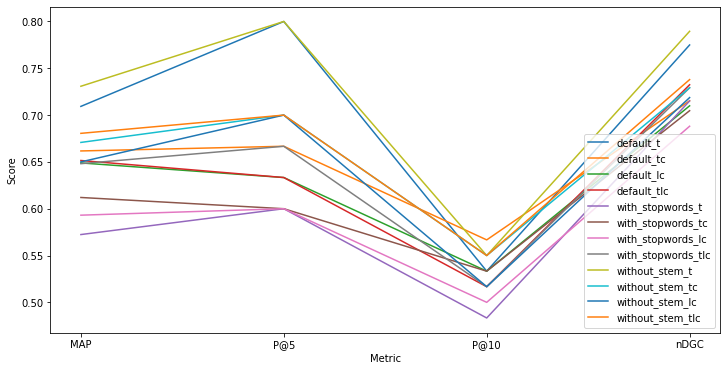

In [113]:
import matplotlib.pyplot as plt
import numpy as np

fig = plt.gcf()
plt.rcParams["figure.figsize"] = (12,6)
fig, ax = plt.subplots()
ax.plot(df.index, df)
ax.set(xlabel="Metric", ylabel="Score")
ax.legend(df.columns, loc="lower right")
plt.show()

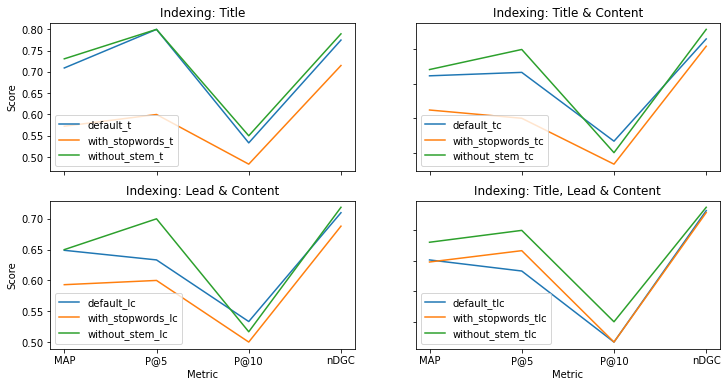

In [114]:
index_title = df[["default_t", 'with_stopwords_t', 'without_stem_t']]
index_title_content = df[["default_tc", 'with_stopwords_tc', 'without_stem_tc']]
index_lead_content = df[["default_lc", 'with_stopwords_lc', 'without_stem_lc']]
index_title_lead_content = df[["default_tlc", 'with_stopwords_tlc', 'without_stem_tlc']]

fig, axs = plt.subplots(2, 2)
axs[0, 0].plot(df.index, index_title)
axs[0, 0].set_title('Indexing: Title')
axs[0, 0].legend(index_title)

axs[0, 1].plot(df.index, index_title_content)
axs[0, 1].set_title('Indexing: Title & Content')
axs[0, 1].legend(index_title_content)

axs[1, 0].plot(df.index, index_lead_content)
axs[1, 0].set_title('Indexing: Lead & Content')
axs[1, 0].legend(index_lead_content)

axs[1, 1].plot(df.index, index_title_lead_content)
axs[1, 1].set_title('Indexing: Title, Lead & Content')
axs[1, 1].legend(index_title_lead_content)

for ax in axs.flat:
    ax.set(xlabel='Metric', ylabel='Score')

for ax in axs.flat:
    ax.label_outer()

plt.show()

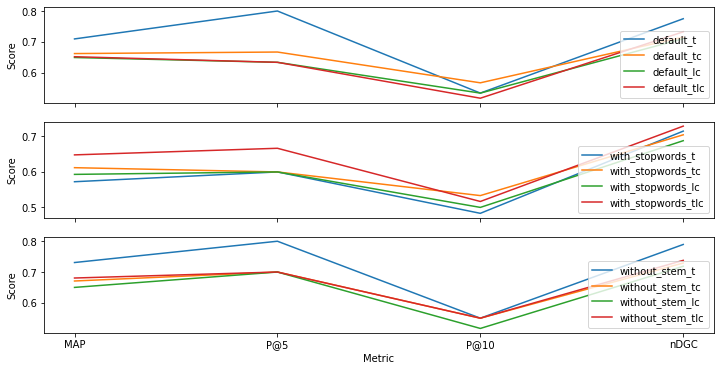

In [115]:
main_conf = df.iloc[:,[0,1,2,3]]
with_stopwords = df.iloc[:,[4,5,6,7]]
without_stem = df.iloc[:,[8,9,10,11]]

fig, axs = plt.subplots(3, 1, sharex=True)
axs[0].plot(df.index, main_conf)
#axs[0].set_title('Configuration: Default')
axs[0].legend(main_conf, loc="lower right")

axs[1].plot(df.index, with_stopwords)
#axs[1].set_title('Configuration: With Stopwords')
axs[1].legend(with_stopwords, loc="lower right")

axs[2].plot(df.index, without_stem)
#axs[2].set_title('Configuration: Without Stemming')
axs[2].legend(without_stem, loc="lower right")

for ax in axs.flat:
    ax.set(xlabel='Metric', ylabel='Score')

for ax in axs.flat:
    ax.label_outer()

plt.show()